In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from path import Path
from collections import Counter
# import s3fs
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
all_countries_df = pd.read_csv(Path("../Resources/all_countries.csv"), index_col=0)

all_countries_df

,Country,Year,GDP_per_capita,Population,Metric_Tons
0,Albania,2017,12770.963867,2884169.0,16481.0
1,Albania,2018,13317.092773,2882735.0,18094.0
2,Albania,2019,13656.592773,2880913.0,18500.0
3,Albania,2020,13191.952148,2877800.0,20157.0
4,Algeria,2017,11737.401367,41389174.0,153459.0
...,...,...,...,...,...
491,Uruguay,2020,21608.429688,3473727.0,110834.0
492,Vanuatu,2017,3081.835205,285499.0,868.0
493,Vanuatu,2018,3093.461426,292675.0,841.0
494,Vanuatu,2019,3137.240967,299882.0,997.0


In [5]:
all_countries_df.sort_values('Metric_Tons', ascending=False)

,Country,Year,GDP_per_capita,Population,Metric_Tons
79,China,2020,16315.815430,1.439324e+09,2777198.0
78,China,2019,15977.645508,1.433784e+09,2683611.0
77,China,2018,15133.996094,1.427648e+09,2498228.0
76,China,2017,14243.532227,1.421022e+09,2290405.0
371,Philippines,2020,7953.581543,1.095811e+08,1703846.0
...,...,...,...,...,...
248,Kiribati,2017,2235.707275,1.141530e+05,16.0
42,Belgium,2019,51944.167969,1.153933e+07,16.0
214,Iceland,2019,56935.773438,3.390370e+05,15.0
213,Iceland,2018,56818.195312,3.367120e+05,14.0


In [6]:
all_countries_bins_df = all_countries_df.dropna(how='all')
all_countries_bins_df

,Country,Year,GDP_per_capita,Population,Metric_Tons
0,Albania,2017,12770.963867,2884169.0,16481.0
1,Albania,2018,13317.092773,2882735.0,18094.0
2,Albania,2019,13656.592773,2880913.0,18500.0
3,Albania,2020,13191.952148,2877800.0,20157.0
4,Algeria,2017,11737.401367,41389174.0,153459.0
...,...,...,...,...,...
491,Uruguay,2020,21608.429688,3473727.0,110834.0
492,Vanuatu,2017,3081.835205,285499.0,868.0
493,Vanuatu,2018,3093.461426,292675.0,841.0
494,Vanuatu,2019,3137.240967,299882.0,997.0


In [7]:
# all_countries_bins_df.describe()
all_countries_bins_df.describe(percentiles=[0, 1/3, 2/3, 1])

,Year,GDP_per_capita,Population,Metric_Tons
count,492.000000,492.000000,4.920000e+02,4.920000e+02
mean,2018.500000,20689.958433,4.844674e+07,8.422285e+04
std,1.119172,18513.595598,1.794625e+08,2.956064e+05
min,2017.000000,1079.112427,1.780900e+04,9.000000e+00
0%,2017.000000,1079.112427,1.780900e+04,9.000000e+00
33.3%,2018.000000,8582.505208,3.278150e+06,1.596333e+03
50%,2018.500000,14404.688477,7.674312e+06,5.878500e+03
66.7%,2019.000000,23415.389323,1.810052e+07,2.303100e+04
100%,2020.000000,91738.750000,1.439324e+09,2.777198e+06
max,2020.000000,91738.750000,1.439324e+09,2.777198e+06


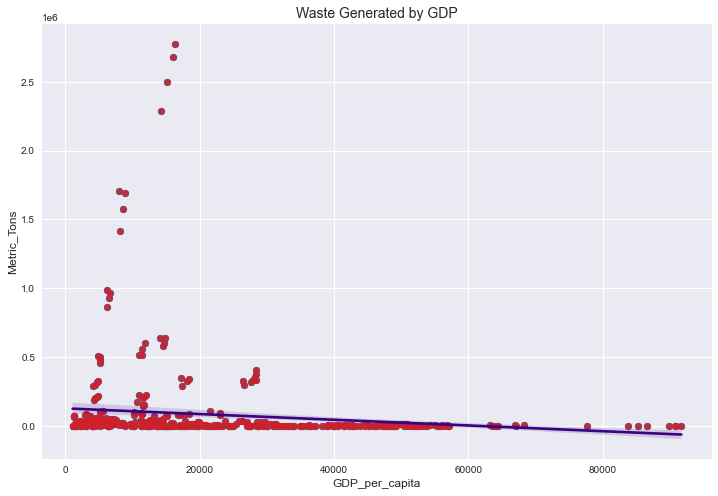

In [8]:
# Visualize the data

%matplotlib inline

plt.style.use('seaborn')
plt.figure(2, figsize=(12,8))

plt.scatter(all_countries_bins_df['GDP_per_capita'], all_countries_bins_df['Metric_Tons'])
plt.title('Waste Generated by GDP', loc='center', fontsize=14)
plt.ylabel('Waste per person(kg/day)', loc='center', fontsize=12)
plt.xlabel('GDP per capita in PPP', fontsize=12)

sns.regplot(x=all_countries_bins_df['GDP_per_capita'], y=all_countries_bins_df['Metric_Tons'],
           scatter_kws={'color': '#CD212A'}, line_kws={'color': '#380282'})

plt.show()

In [9]:
all_countries_bins_df.describe().applymap(lambda x: f"{x:0.2f}")

,Year,GDP_per_capita,Population,Metric_Tons
count,492.00,492.00,492.00,492.00
mean,2018.50,20689.96,48446738.34,84222.85
std,1.12,18513.60,179462450.94,295606.45
min,2017.00,1079.11,17809.00,9.00
25%,2017.75,5450.18,1402111.50,512.50
50%,2018.50,14404.69,7674312.50,5878.50
75%,2019.25,30073.45,31602349.50,31812.50
max,2020.00,91738.75,1439323774.00,2777198.00


In [10]:
# #Put all Metric Tons values into quartile bins
# all_countries_bins_df['Metric_Tons'] = pd.cut(all_countries_bins_df.Metric_Tons, bins=4,
#        labels=['low', 'medium', 'high', 'extreme'])

In [11]:
# Put all Metric Tons into bins
custom_bins = [0, 512, 5878, 31812, 2800000]
all_countries_bins_df['Metric_Tons'] = pd.cut(all_countries_bins_df.Metric_Tons, bins=custom_bins, right=True,
                    labels=['low', 'medium', 'high', 'extreme'])

In [12]:
all_countries_bins_df

,Country,Year,GDP_per_capita,Population,Metric_Tons
0,Albania,2017,12770.963867,2884169.0,high
1,Albania,2018,13317.092773,2882735.0,high
2,Albania,2019,13656.592773,2880913.0,high
3,Albania,2020,13191.952148,2877800.0,high
4,Algeria,2017,11737.401367,41389174.0,extreme
...,...,...,...,...,...
491,Uruguay,2020,21608.429688,3473727.0,extreme
492,Vanuatu,2017,3081.835205,285499.0,medium
493,Vanuatu,2018,3093.461426,292675.0,medium
494,Vanuatu,2019,3137.240967,299882.0,medium


In [13]:
target = ['Metric_Tons']

##  Split the Data into Training and Testing

In [14]:
# Create our features
X = all_countries_bins_df.drop(columns='Metric_Tons')
X = pd.get_dummies(X)

# Create our target
y = all_countries_bins_df.loc[:, target].copy()

In [15]:
X.describe()

,Year,GDP_per_capita,Population,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Australia,Country_Bahamas,...,Country_Thailand,Country_Togo,Country_Tonga,Country_Trinidad and Tobago,Country_Tunisia,Country_Turkey,Country_Ukraine,Country_United Arab Emirates,Country_Uruguay,Country_Vanuatu
count,492.000000,492.000000,4.920000e+02,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,2018.500000,20689.958433,4.844674e+07,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,...,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130
std,1.119172,18513.595598,1.794625e+08,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,...,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891,0.089891
min,2017.000000,1079.112427,1.780900e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.750000,5450.180542,1.402112e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.500000,14404.688477,7.674312e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.250000,30073.445312,3.160235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,91738.750000,1.439324e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Check the balance of our target values
y['Metric_Tons'].value_counts()

low        123
medium     123
high       123
extreme    123
Name: Metric_Tons, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

##  Oversampling

###  Naive Random Oversampling

In [18]:
 # Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'Metric_Tons': 1})

In [19]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [20]:
LogisticRegression(random_state=1)

LogisticRegression(random_state=1)

In [21]:
 # Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5431034482758621

In [22]:
 # Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[26,  0,  1,  2],
       [11,  0, 11, 10],
       [ 0,  0, 33,  0],
       [ 3,  0, 18,  8]], dtype=int64)

In [23]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    extreme       0.65      0.90      0.85      0.75      0.87      0.77        29
       high       0.00      0.00      1.00      0.00      0.00      0.00        32
        low       0.52      1.00      0.67      0.69      0.82      0.69        33
     medium       0.40      0.28      0.87      0.33      0.49      0.23        29

avg / total       0.39      0.54      0.85      0.44      0.54      0.42       123



###  SMOTE Oversampling

In [24]:
# # Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)



Counter({'Metric_Tons': 1})

In [25]:
 Counter({'Metric_Tons': 1})

Counter({'Metric_Tons': 1})

In [26]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [27]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5743534482758621

In [28]:
 # Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[26,  0,  1,  2],
       [ 9,  4, 11,  8],
       [ 0,  0, 33,  0],
       [ 3,  0, 18,  8]], dtype=int64)

In [29]:
 # Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    extreme       0.68      0.90      0.87      0.78      0.88      0.78        29
       high       1.00      0.12      1.00      0.22      0.35      0.11        32
        low       0.52      1.00      0.67      0.69      0.82      0.69        33
     medium       0.44      0.28      0.89      0.34      0.50      0.23        29

avg / total       0.67      0.58      0.86      0.51      0.64      0.45       123



###  Undersampling

In [30]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)

Counter({'Metric_Tons': 1})

In [31]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [32]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5431034482758621

In [33]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[26,  0,  1,  2],
       [11,  0, 10, 11],
       [ 0,  0, 33,  0],
       [ 3,  0, 18,  8]], dtype=int64)

In [34]:
 # Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    extreme       0.65      0.90      0.85      0.75      0.87      0.77        29
       high       0.00      0.00      1.00      0.00      0.00      0.00        32
        low       0.53      1.00      0.68      0.69      0.82      0.70        33
     medium       0.38      0.28      0.86      0.32      0.49      0.22        29

avg / total       0.39      0.54      0.85      0.44      0.54      0.42       123



In [35]:
 # Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    extreme       0.65      0.90      0.85      0.75      0.87      0.77        29
       high       0.00      0.00      1.00      0.00      0.00      0.00        32
        low       0.53      1.00      0.68      0.69      0.82      0.70        33
     medium       0.38      0.28      0.86      0.32      0.49      0.22        29

avg / total       0.39      0.54      0.85      0.44      0.54      0.42       123



In [36]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)

Counter({'Metric_Tons': 1})